In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(future)
    library(combinat)
    library("TxDb.Hsapiens.UCSC.hg38.knownGene")
    library(GenomicRanges)
    library(GenomicFeatures)
    library(rsnps)
    library(biomaRt)
    library(ggpubr)
    library(gridExtra)
    library(patchwork)
    library(EnhancedVolcano)
    library(rlist)
    library(purrr)
}))
options(timeout=100000)
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

# Definitions etc

In [2]:
set.seed(1234, "L'Ecuyer-CMRG")
options(digits=2)
stats <- c()

In [3]:
options(future.globals.maxSize= 250 * 1024^3) # 650Gb
# plan()

# Enable parallelization
plan(sequential)
plan("multicore", workers = 16)

In [4]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S2/analysis/secondary/"
    save_seurat_h5 = "YES"
}

In [5]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

Mark cells that are positive for given guides as guide_positive, all others as guide_negative

In [6]:
mark_guide_pos_neg <- function(seurat_obj, perturbed_cells_by_guide, guides, print_counts = T) {
    all_cells = Cells(seurat_obj)
    perturbed_cells = c()
    dummy_perturbed = c()
    
    for(guide in guides) {
        dummy_perturbed = unlist(perturbed_cells_by_guide[[guide]])
        perturbed_cells = union(perturbed_cells, dummy_perturbed)
        #cat(guide," ", length(perturbed_cells), "\n")
    }

    unperturbed_cells = unlist(setdiff(all_cells, perturbed_cells))
    Idents(seurat_obj) <- "guide_negative"
    seurat_obj <- SetIdent(seurat_obj, cells = perturbed_cells, value = "guide_positive") 

    if(print_counts) {
        n_gplus   = length(perturbed_cells)
        n_gminus = length(unperturbed_cells)    
        cat(blue("Guide+ =",n_gplus, "; Guide- =", n_gminus, "\n"))
    }
    
    seurat_obj
}

### Load guide df

In [7]:
df_guide = read.table("/home/vsevim/prj/1012-ckd/S2/scripts/library_csv/101_CRISPRa_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
sample_n(df_guide, 6)

gene,guide1,guide2,alias,subclass,class,gene_or_rsid,label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Enh-13-1-CTSB,CTSB-1a,CTSB-1b,CTSB,de_control,targeting,CTSB,Control DE
FGF5,FGF5-1a,FGF5-1b,FGF5,tss,targeting,FGF5,Control TSS
rs4859682,DE23-1a,DE23-1b,DE23,ckd_de,targeting,rs4859682,CKD DE
rs527616,DE5-2a,DE5-2b,DE5,ckd_de,targeting,rs527616,CKD DE
17_37852066,DE20-1a,DE20-1b,DE20,ckd_de_no_rs,targeting,17_37852066,CKD DE
rs11123169,DE21-1a,DE21-1b,DE21,ckd_de,targeting,rs11123169,CKD DE


### Load Seurat file

In [8]:
integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S2/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
seurat_combined    <- LoadH5Seurat(integrated_h5_path, verbose = F)
#seurat_combined    <- subset(seurat_combined, subset=status=='singlet')

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


Normalize RNA counts by <font color='red'>NormalizeData</font>  before running FindMarkers

In [9]:
seurat_rna = CreateSeuratObject(seurat_combined[['RNA']])
seurat_rna <- NormalizeData(seurat_rna)
seurat_rna@meta.data <- seurat_combined@meta.data

### Load THRESHOLDS.tsv

In [10]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds = read.table(thr_f_name, header=T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)

## Select perturbed/control cells
Find guide+ (perturbed) and guide- (unperturbed) cells for each guide

In [11]:
libraries = unique(seurat_combined$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined, subset = library == lib)
}
names(seurat_libs) <- libraries

In [12]:
cat(red("Using 3x threshold"))
THRESHOLD_MULTIPLIER = 3

perturbed_cells_by_guide = list()

for(i in 1:nrow(df_thresholds)){  
    perturbed_cells_in_all_libs = list()
    guide = df_thresholds$guide[i]
    # Loop over libraries
    for(lib in libraries){        
        seurat_lib = seurat_libs[[lib]]
        threshold = THRESHOLD_MULTIPLIER * df_thresholds[i, lib]        
        #cat(blue(guide, lib, threshold, "\n"))
        cells_in_lib = Cells(seurat_lib)        
        sgrna_counts = seurat_lib[['sgRNA']]@counts
        select_perturbed = sgrna_counts[guide, cells_in_lib] >= threshold
        perturbed_cells_in_library = cells_in_lib[select_perturbed]
        #cat(length(cells_in_lib), "in", lib, guide, length(perturbed_cells_in_library), "cells >", threshold, "\n")        
        if(!is.na(threshold)) {
            perturbed_cells_in_all_libs = append(perturbed_cells_in_all_libs, perturbed_cells_in_library)
        }
    }
    perturbed_cells_by_guide[[i]] = perturbed_cells_in_all_libs
}
names(perturbed_cells_by_guide) <- df_thresholds$guide

Using 3x threshold

In [13]:
length(perturbed_cells_by_guide[[3]])

[1] 244

In [14]:
df_thresholds$guide[grepl("NT" , df_thresholds$guide)]

[1] "NTCE1-1a" "NTCE3-1a" "NTCE3-1b" "NTCE4-1a" "NTCE4-1b"

# Check DE for genes near SNPs

In [15]:
select_distal  = df_guide$subclass == 'ckd_de'
df_snps = unique(df_guide[select_distal, c('gene','alias')])

* * * * *
I skip DE 20 because it doesn't have a rsID. Use it's coords instead 
* * * * *

In [16]:
snp_coords = ncbi_snp_query(df_snps$gene)

Getting info about the following rsIDs: rs2823139, rs7642977, rs78581838, rs7707989, rs527616, rs10283362, rs34861762, rs16874072, rs881858, rs4669722, rs76839935, rs6839100, rs11154336, rs4720089, rs2979488, rs2661503, rs10224210, rs77924615, rs35716097, rs11123169, rs4473129, rs4859682, rs9529913, rs55785724, rs2472297, rs11160318, rs12509595



In [17]:
#snp_upstream_range   = 1000000
#snp_downstream_range = 1000000

df_snp_coords                 = data.frame(chr=paste0("chr", snp_coords$chromosome))
df_snp_coords$start_position  = snp_coords$bp #+ snp_upstream_range
df_snp_coords$end_position    = snp_coords$bp #+ snp_downstream_range
df_snp_coords$strand          = '*'
df_snp_coords$hgnc_symbol     = snp_coords$rsid
df_snp_coords$chromosome_name = snp_coords$chromosome
#snp_granges = makeGRangesFromDataFrame(df_dummy)

Include distal elements with no rs number

In [18]:
select_distal  = df_guide$subclass == 'ckd_de_no_rs'
df_nors_snps = unique(df_guide[select_distal, c('gene','alias')])
chr_and_coords = str_split(df_nors_snps$gene, "_")
df_dummy = data.frame(t(Reduce(rbind, chr_and_coords)))
colnames(df_dummy) <- c("chr", "start")

df_nors_snps$chr = paste0('chr', df_dummy$chr)
df_nors_snps$start_position  = as.numeric(df_dummy$start)
df_nors_snps$end_position    = as.numeric(df_dummy$start)
df_nors_snps$strand          = "*"
df_nors_snps$hgnc_symbol     = df_nors_snps$gene
df_nors_snps$chromosome_name = df_dummy$chr

In [19]:
select_cols = c('chr', 'start_position', 'end_position','strand', 'hgnc_symbol', 'chromosome_name')
df_nors_snps = df_nors_snps[, select_cols]
df_snp_coords = rbind(df_snp_coords, df_nors_snps)

In [20]:
head(df_snp_coords)

,chr,start_position,end_position,strand,hgnc_symbol,chromosome_name
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,chr21,1.5e+07,1.5e+07,*,rs2823139,21
2,chr3,1.9e+08,1.9e+08,*,rs7642977,3
3,chr21,1.5e+07,1.5e+07,*,rs78581838,21
4,chr5,6.8e+07,6.8e+07,*,rs7707989,5
5,chr18,2.7e+07,2.7e+07,*,rs527616,18
6,chr8,1.3e+08,1.3e+08,*,rs10283362,8


Load annotations

In [21]:
#searchDatasets(mart = ensembl, pattern = "hsapiens")
#mart <- useMart("ensembl")
#mart <- useDataset("hsapiens_gene_ensembl", mart)

# Find neighbors of targets

In [22]:
genes_in_assay = rownames(seurat_rna[['RNA']]@counts)
options(timeout=100000)
mart <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl", mirror="useast")
#m <- useMart('ensembl', dataset='hsapiens_gene_ensembl') # create a mart object

In [23]:
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')
control_targets = unique(filter(df_guide, subclass=='tss' | subclass == 'de_control')[,c('alias')])

df_target_coords <- getBM(mart=mart, attributes=c('hgnc_symbol', 'description', 'chromosome_name',
                                 'start_position', 'end_position', 'strand',
                                 'ensembl_gene_id'),
                        filters = 'hgnc_symbol', values = control_targets)
                        
df_target_coords <- filter(df_target_coords, chromosome_name %in% c(1:23, "X","Y"))

In [24]:
gene_neighbors_list = get_neighboring_genes(bm, df_target_coords, genes_in_assay)
snp_neighbors_list  = get_neighboring_genes(bm, df_snp_coords, genes_in_assay)
neighbors_list =  append(gene_neighbors_list, snp_neighbors_list) 

ANPEP 15 88784895 90815401 
BDKRB2 14 95204679 97244166 
C15orf40 15 81988441 84011641 
CD55 1 206321519 208386804 
CSTB 21 42772511 44776330 
CTSB 8 10842524 12869533 
FGF5 4 79266639 81336680 
FGFR3 4 793293 2808872 
FTH1 11 60959718 62967634 
FUBP1 1 76944055 78979110 
ICAM2 17 63002594 65020634 
IQGAP2 5 75403285 77708132 
KLF6 10 2775996 4785281 
LGALS3 14 54124110 56145423 
MAFF 22 37200767 39216507 
NT5E 6 84449584 86495791 
PLIN3 19 3838341 5867694 
SLC34A1 5 176379235 178398848 
TKT 3 52224712 54256052 
UMOD 16 19333051 21356301 
rs2823139 21 14204463 16204463 
rs7642977 3 193092961 195092961 
rs78581838 21 13864259 15864259 
rs7707989 5 67396052 69396052 
rs527616 18 25757460 27757460 
rs10283362 8 132320717 134320717 
rs34861762 8 22890907 24890907 
rs16874072 4 22741827 24741827 
rs881858 6 42838872 44838872 
rs4669722 2 10390110 12390110 
rs76839935 7 150870466 152870466 
rs6839100 4 75458036 77458036 
rs11154336 6 124899862 126899862 
rs4720089 7 31964026 33964026 
rs2979

In [25]:
list.save(neighbors_list, "/home/vsevim/prj/1012-ckd/S2/scripts/library_csv/neighbors_list.rds")

## Run diffex on genes neighboring the snps w/ min_LFC = 0.10

In [28]:
df_targets = unique(filter(df_guide, subclass=='ckd_de')[,c('alias','gene','subclass', 'label')])
df_targets = unique(filter(df_guide, class=='targeting')[,c('alias','gene','subclass', 'label')])
df_neighbor_de = NULL
test_use = "LR" #"MAST"  #"wilcox" "LR"
guides_to_skip = c()  #c("DE6", "DE15")  
logfc_threshold = 0.20

for(i in 1:nrow(df_targets)) {
    target          = df_targets[i,'alias']
    target_subclass = df_targets[i, 'subclass']
    label           = df_targets[i, 'label']
    snp_id_or_gene_name = df_targets[i,'gene']
    
    if(!str_detect(target, regex("^DE\\d+$"))) {
        ckd_de = 
        neigbors = neighbors_list[[target]]
    } else {
        neigbors = neighbors_list[[snp_id_or_gene_name]]
    }

    if((target %in% guides_to_skip) | length(neigbors) == 0 ){
        cat(red("Skipping", target, snp_id_or_gene_name, length(neigbors), "\n"))
        next
    }
    guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
    cat(blue(target, target,":"), paste(guides_4_target, collapse=","),"\n")
    seurat_dummy <- mark_guide_pos_neg(seurat_rna, perturbed_cells_by_guide, guides_4_target, print_counts = T)
    
    markers <- FindMarkers(
        object = seurat_dummy,
        features = NULL, 
        slot = "data",
        ident.1 = 'guide_positive',
        ident.2 = 'guide_negative',
        test.use = test_use,
        logfc.threshold = logfc_threshold,
        latent.vars = c("library", "donor"),
        only.pos = FALSE, 
        verbose = FALSE
    )
    # 
    # latent.vars = c('library') 
    if(nrow(markers)==0) {
        cat(red("No DE genes", test_use,":", target, "\n"))
        next
    } 
    markers$de_gene = rownames(markers)
    markers$target = target
    markers$subclass = target_subclass
    markers$label = label
    rownames(markers) <- NULL
    df_neighbor_de = rbind(df_neighbor_de, markers)
    print(markers)
}

In [ ]:
#rownames(df_neighbor_de) <- df_neighbor_de$de_gene
head(df_neighbor_de[df_neighbor_de$target == "CSTB",], 20)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
141,3.7e-21,0.236,0.95,0.93,1.3e-16,CSTB,CSTB,de_control,Control DE
142,1.4e-04,0.044,0.77,0.72,1.0e+00,NDUFV3,CSTB,de_control,Control DE
143,2.0e-02,0.022,0.27,0.23,1.0e+00,RRP1,CSTB,de_control,Control DE
144,3.3e-02,-0.042,0.55,0.55,1.0e+00,PFKL,CSTB,de_control,Control DE
145,6.7e-02,0.014,0.76,0.73,1.0e+00,PDXK,CSTB,de_control,Control DE
146,7.1e-02,0.024,0.45,0.41,1.0e+00,RRP1B,CSTB,de_control,Control DE
147,1.7e-01,0.011,0.69,0.65,1.0e+00,AGPAT3,CSTB,de_control,Control DE
148,1.7e-01,-0.032,0.34,0.33,1.0e+00,PKNOX1,CSTB,de_control,Control DE
149,1.9e-01,-0.027,0.40,0.38,1.0e+00,PDE9A,CSTB,de_control,Control DE


### Correct p-values by total number of comparisons

In [ ]:
n_tests = length(flatten(neighbors_list))
print(n_tests)
df_neighbor_de$p_val_adj_mine =  p.adjust(
    p = df_neighbor_de$p_val,
    method = "bonferroni",
    n = n_tests
)


[1] 1219


In [ ]:
select_significant_p  = df_neighbor_de$p_val_adj_mine < 1
df_neighbor_de        = df_neighbor_de[select_significant_p,]
head(df_neighbor_de[df_neighbor_de$target == "CSTB",], 20)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
141,3.7e-21,0.236,0.95,0.93,1.3e-16,CSTB,CSTB,de_control,Control DE,4.5e-18
142,1.4e-04,0.044,0.77,0.72,1.0e+00,NDUFV3,CSTB,de_control,Control DE,1.7e-01


In [ ]:
head(df_neighbor_de, 20)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,1.2e-05,-0.203,0.744,0.774,4.3e-01,SEMA4B,ANPEP,tss,Control TSS,1.4e-02
20,1.1e-10,0.365,0.862,0.731,4.1e-06,SNHG5,NT5E,tss,Control TSS,1.4e-07
21,7.2e-09,-0.209,0.669,0.733,2.6e-04,NT5E,NT5E,tss,Control TSS,8.7e-06
25,8.5e-05,-0.100,0.064,0.101,1.0e+00,PTGFR,FUBP1,tss,Control TSS,1.0e-01
35,8.1e-13,-0.172,0.301,0.464,3.0e-08,C15orf40,C15orf40,tss,Control TSS,9.9e-10
36,5.1e-06,0.165,0.959,0.964,1.9e-01,RPS17,C15orf40,tss,Control TSS,6.3e-03
43,3.8e-05,-0.064,0.140,0.219,1.0e+00,MAFF,MAFF,tss,Control TSS,4.7e-02
70,1.5e-35,0.214,1.000,0.999,5.5e-31,FTH1,FTH1,de_control,Control DE,1.8e-32
71,1.8e-18,0.135,0.874,0.814,6.7e-14,TMEM258,FTH1,de_control,Control DE,2.2e-15


In [ ]:
nrow(df_neighbor_de)
head(df_neighbor_de)

[1] 101

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,1.2e-05,-0.20,0.744,0.77,4.3e-01,SEMA4B,ANPEP,tss,Control TSS,1.4e-02
20,1.1e-10,0.37,0.862,0.73,4.1e-06,SNHG5,NT5E,tss,Control TSS,1.4e-07
21,7.2e-09,-0.21,0.669,0.73,2.6e-04,NT5E,NT5E,tss,Control TSS,8.7e-06
25,8.5e-05,-0.10,0.064,0.10,1.0e+00,PTGFR,FUBP1,tss,Control TSS,1.0e-01
35,8.1e-13,-0.17,0.301,0.46,3.0e-08,C15orf40,C15orf40,tss,Control TSS,9.9e-10
36,5.1e-06,0.16,0.959,0.96,1.9e-01,RPS17,C15orf40,tss,Control TSS,6.3e-03


## Volcano Plot

In [ ]:
colors <- ifelse(
    df_neighbor_de$subclass == 'tss', 'black',
    ifelse(df_neighbor_de$subclass == 'de_control', 'gray', 'green') 
)
names(colors) <- df_neighbor_de$label

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"ggrepel: 9 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


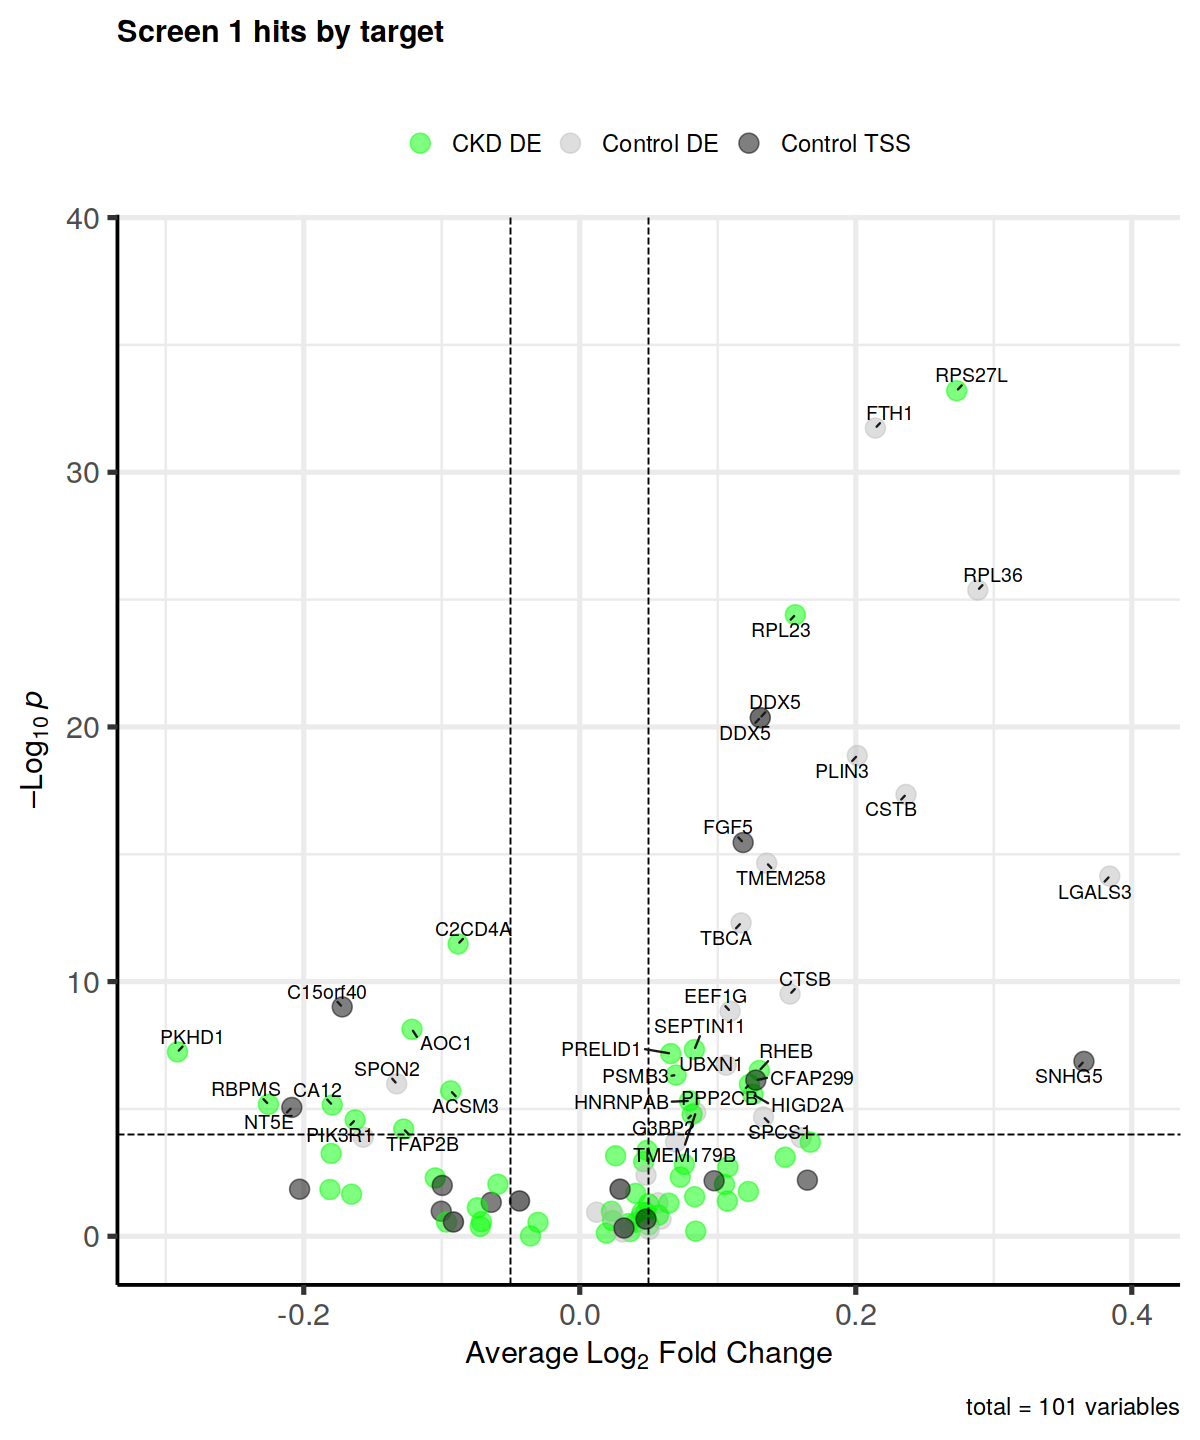

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 12)
EnhancedVolcano(df_neighbor_de, 
                lab = df_neighbor_de$de_gene,
                x ="avg_log2FC",
                y ="p_val_adj_mine",
                title = 'Screen 1 hits by target',
                subtitle = '', 
                colCustom = colors,
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-5,
                FCcutoff = 0.05,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-.3, .4) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

# lab = df_neighbor_de$de_gene,
# drawConnectors = TRUE,

# Inpect DE results

Print top high-confidence hits

In [ ]:
df_neighbor_de %>% filter(avg_log2FC > 0) %>% arrange(p_val_adj_mine) %>% head(10)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,5.2e-37,0.27,0.98,0.96,1.9e-32,RPS27L,DE22,ckd_de,CKD DE,6.3e-34
2,1.5e-35,0.21,1.00,1.00,5.5e-31,FTH1,FTH1,de_control,Control DE,1.8e-32
3,3.5e-29,0.29,0.99,0.98,1.3e-24,RPL36,PLIN3,de_control,Control DE,4.2e-26
4,3.2e-28,0.16,0.99,0.98,1.2e-23,RPL23,DE20,ckd_de_no_rs,CKD DE,3.9e-25
5,3.6e-24,0.13,0.95,0.94,1.3e-19,DDX5,ICAM2,de_control,Control DE,4.3e-21
6,3.6e-24,0.13,0.95,0.94,1.3e-19,DDX5,ICAM2,tss,Control TSS,4.3e-21
7,1.1e-22,0.20,0.72,0.63,4.0e-18,PLIN3,PLIN3,de_control,Control DE,1.3e-19
8,3.7e-21,0.24,0.95,0.93,1.3e-16,CSTB,CSTB,de_control,Control DE,4.5e-18
9,2.8e-19,0.12,0.24,0.14,1.0e-14,FGF5,FGF5,tss,Control TSS,3.5e-16


In [ ]:
df_neighbor_de %>% filter((subclass == 'tss')) %>% arrange(p_val_adj_mine) %>% head(30)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,3.6e-24,0.131,0.953,0.94,1.3e-19,DDX5,ICAM2,tss,Control TSS,4.3e-21
2,2.8e-19,0.118,0.242,0.14,1.0e-14,FGF5,FGF5,tss,Control TSS,3.5e-16
3,8.1e-13,-0.172,0.301,0.46,3.0e-08,C15orf40,C15orf40,tss,Control TSS,9.9e-10
4,1.1e-10,0.365,0.862,0.73,4.1e-06,SNHG5,NT5E,tss,Control TSS,1.4e-07
5,6.1e-10,0.128,0.241,0.16,2.2e-05,CFAP299,FGF5,tss,Control TSS,7.4e-07
6,7.2e-09,-0.209,0.669,0.73,2.6e-04,NT5E,NT5E,tss,Control TSS,8.7e-06
7,5.1e-06,0.165,0.959,0.96,1.9e-01,RPS17,C15orf40,tss,Control TSS,6.3e-03
8,5.4e-06,0.097,0.827,0.79,2.0e-01,PRELID1,SLC34A1,tss,Control TSS,6.6e-03
9,8.3e-06,-0.100,0.198,0.25,3.0e-01,ACSM3,UMOD,tss,Control TSS,1.0e-02


In [ ]:
df_neighbor_de %>% filter((subclass == 'ckd_de') & (p_val_adj_mine < 0.05)) %>% arrange(p_val_adj_mine) 

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
5.2e-37,0.273,0.981,0.96,1.9e-32,RPS27L,DE22,ckd_de,CKD DE,6.3e-34
2.7e-15,-0.088,0.059,0.11,1.0e-10,C2CD4A,DE22,ckd_de,CKD DE,3.3e-12
6.1e-12,-0.122,0.091,0.17,2.2e-07,AOC1,DE17,ckd_de,CKD DE,7.4e-09
3.8e-11,0.083,0.835,0.80,1.4e-06,SEPTIN11,DE23,ckd_de,CKD DE,4.7e-08
4.7e-11,-0.291,0.498,0.58,1.7e-06,PKHD1,DE16,ckd_de,CKD DE,5.8e-08
5.5e-11,0.066,0.852,0.79,2.0e-06,PRELID1,DE19,ckd_de,CKD DE,6.7e-08
2.5e-10,0.130,0.873,0.80,9.3e-06,RHEB,DE17,ckd_de,CKD DE,3.1e-07
8.9e-10,0.123,0.801,0.73,3.3e-05,PPP2CB,DE15,ckd_de,CKD DE,1.1e-06
1.6e-09,-0.094,0.206,0.25,5.9e-05,ACSM3,DE18,ckd_de,CKD DE,2.0e-06


In [ ]:
df_neighbor_de %>% filter((subclass == 'de_control') & (p_val_adj_mine < 1)) %>% arrange(p_val_adj_mine) 

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1.5e-35,0.214,1.00,0.999,5.5e-31,FTH1,FTH1,de_control,Control DE,1.8e-32
3.5e-29,0.288,0.99,0.985,1.3e-24,RPL36,PLIN3,de_control,Control DE,4.2e-26
3.6e-24,0.131,0.95,0.935,1.3e-19,DDX5,ICAM2,de_control,Control DE,4.3e-21
1.1e-22,0.201,0.72,0.630,4.0e-18,PLIN3,PLIN3,de_control,Control DE,1.3e-19
3.7e-21,0.236,0.95,0.925,1.3e-16,CSTB,CSTB,de_control,Control DE,4.5e-18
1.8e-18,0.135,0.87,0.814,6.7e-14,TMEM258,FTH1,de_control,Control DE,2.2e-15
5.9e-18,0.384,0.92,0.865,2.2e-13,LGALS3,LGALS3,de_control,Control DE,7.2e-15
4.1e-16,0.117,0.94,0.917,1.5e-11,TBCA,IQGAP2,de_control,Control DE,5.0e-13
2.5e-13,0.152,0.99,0.963,9.3e-09,CTSB,CTSB,de_control,Control DE,3.1e-10


## Print top hits w/o log FC filtering

In [ ]:
targets  = unique(df_neighbor_de$target)
col_list = c('target', 'de_gene', 'avg_log2FC', 'p_val_adj_mine', 'label')
df_top_hits = NULL

for(t in targets){
    df_dummy = filter(df_neighbor_de[, col_list], (target == t)) %>% arrange(p_val_adj_mine) %>% head(2)
    #colnames(df_dummy) = NULL
    if(nrow(df_dummy)>0) {
        #print(df_dummy)
        df_top_hits = rbind(df_top_hits, df_dummy)
    }
    else {
        cat(green("Skipping ", t), "\n")
    }
    #cat(yellow("-----------------------------------------------------------\n\n\n"))
}

In [ ]:
#df_top_hits %>% filter(label == "Control TSS")
#df_top_hits %>% filter(label == "Control DE")
df_top_hits %>% filter(label == "CKD DE")

target,de_gene,avg_log2FC,p_val_adj_mine,label
<chr>,<chr>,<dbl>,<dbl>,<chr>
DE3,NRIP1,0.107,1.9e-03,CKD DE
DE4,PIK3R1,-0.163,2.7e-05,CKD DE
DE4,TAF9,0.019,7.5e-01,CKD DE
DE5,CHST9,-0.071,2.7e-01,CKD DE
DE7,TNFRSF10D,0.149,7.9e-04,CKD DE
DE7,TNFRSF10B,0.107,4.2e-02,CKD DE
DE9,HSP90AB1,0.167,2.0e-04,CKD DE
DE9,DNPH1,0.122,1.7e-02,CKD DE
DE10,ODC1,0.065,5.0e-02,CKD DE


## Print top hits w/ avg LogFC >0

In [ ]:
targets  = unique(df_neighbor_de$target)
col_list = c('target', 'de_gene', 'avg_log2FC', 'p_val_adj_mine', 'label')
df_top_hits = NULL

for(t in targets){
    df_dummy = filter(df_neighbor_de[, col_list], (target == t) & (avg_log2FC > 0)) %>% arrange(p_val_adj_mine) %>% head(2)
    #colnames(df_dummy) = NULL   
    if(nrow(df_dummy)>0) {
        #print(df_dummy)
        df_top_hits = rbind(df_top_hits, df_dummy)
    }
    else {
        cat(green("Skipping ", t), "\n")
    }
    #cat(yellow("-----------------------------------------------------------\n\n\n"))
}

Skipping  ANPEP 
Skipping  FUBP1 
Skipping  MAFF 
Skipping  DE5 
Skipping  DE16 
Skipping  DE18 
Skipping  DE21 
Skipping  UMOD 


In [ ]:
df_top_hits %>% filter(label == "CKD DE")

target,de_gene,avg_log2FC,p_val_adj_mine,label
<chr>,<chr>,<dbl>,<dbl>,<chr>
DE3,NRIP1,0.107,1.9e-03,CKD DE
DE4,TAF9,0.019,7.5e-01,CKD DE
DE7,TNFRSF10D,0.149,7.9e-04,CKD DE
DE7,TNFRSF10B,0.107,4.2e-02,CKD DE
DE9,HSP90AB1,0.167,2.0e-04,CKD DE
DE9,DNPH1,0.122,1.7e-02,CKD DE
DE10,ODC1,0.065,5.0e-02,CKD DE
DE11,RHEB,0.073,4.8e-03,CKD DE
DE12,G3BP2,0.105,9.2e-03,CKD DE


# Visualize Knockdowns

## TSS controls

[1] "ANPEP"
CD13-1a   323 
CD13-1b   433 
Guide+ = 433 ; Guide- = 45618 
[1] "CD55"
CD55-1a   244 
CD55-1b   364 
Guide+ = 364 ; Guide- = 45687 
[1] "NT5E"
CD73-1a   289 
CD73-1b   399 
Guide+ = 399 ; Guide- = 45652 
[1] "FUBP1"
FUBP1-1a   191 
FUBP1-1b   313 
Guide+ = 313 ; Guide- = 45738 
[1] "C15orf40"
C15orf40-1a   305 
C15orf40-1b   415 
Guide+ = 415 ; Guide- = 45636 
[1] "MAFF"
MAFF-1a   232 
MAFF-1b   321 
Guide+ = 321 ; Guide- = 45730 
[1] "UMOD"
UMOD-1a   740 
UMOD-1b   1018 
Guide+ = 1018 ; Guide- = 45033 
[1] "SLC34A1"
SLC34A1-1a   410 
SLC34A1-1b   583 
Guide+ = 583 ; Guide- = 45468 
[1] "BDKRB2"
BDKRB2-1a   651 
BDKRB2-1b   886 
Guide+ = 886 ; Guide- = 45165 
[1] "ICAM2"
ICAM2-1a   902 
ICAM2-2a   1488 
ICAM2tss-1a   2204 
ICAM2-1b   2438 
ICAM2-2b   2595 
ICAM2tss-1b   2806 
Guide+ = 2806 ; Guide- = 43245 
[1] "FGF5"
FGF5-1a   778 
FGF5-1b   1018 
Guide+ = 1018 ; Guide- = 45033 


$`1`

$`2`

attr(,"class")
[1] "list"      "ggarrange"

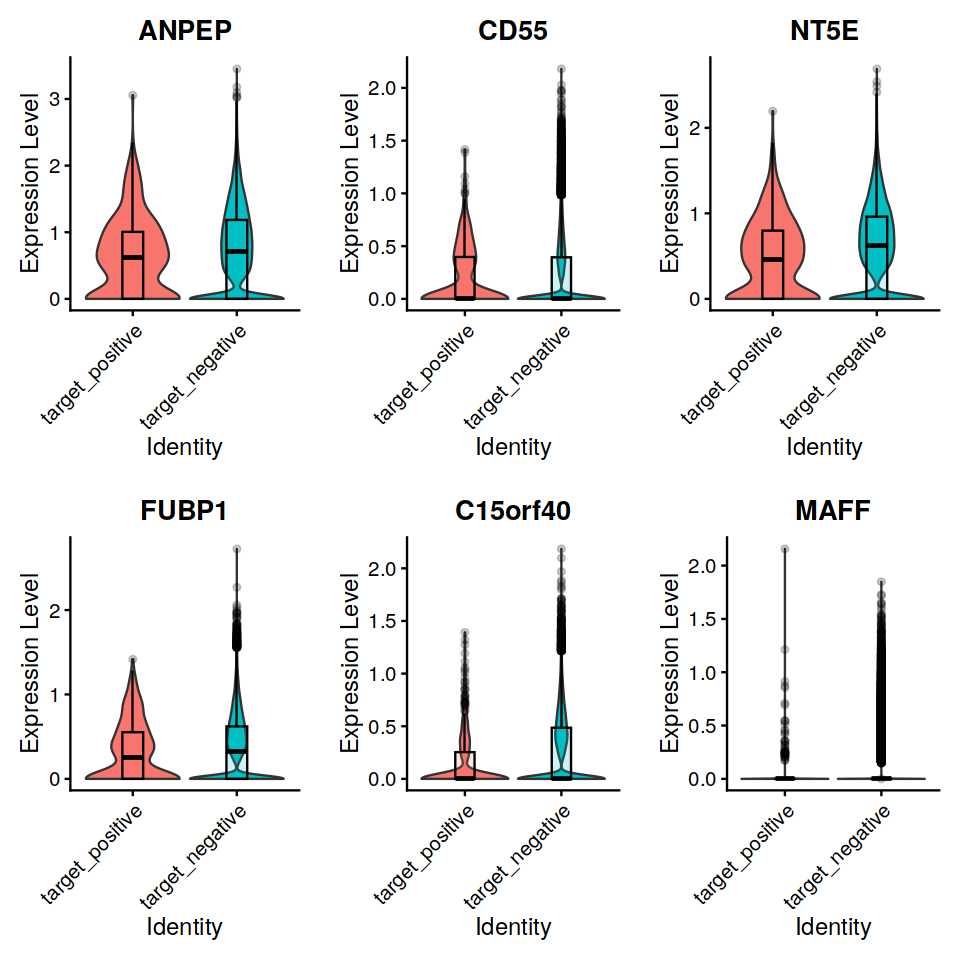

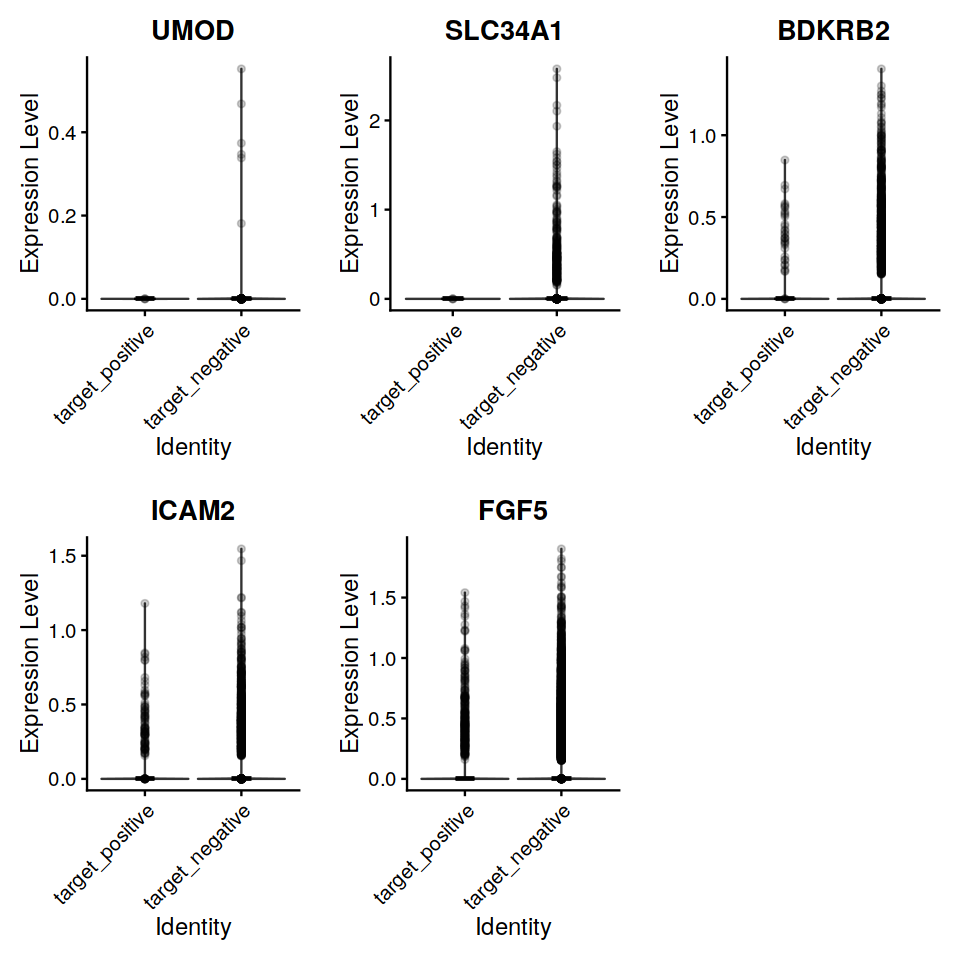

In [ ]:
targets = unique(filter(df_guide, subclass=='tss')$alias)
plots = vlnplot_for_targets(seurat_rna, df_guide, perturbed_cells_by_guide, targets)
options(repr.plot.width=8, repr.plot.height=8)
ggarrange(plotlist=plots, ncol=3, nrow = 2)

## DE controls

[1] "FTH1"
FTH1-1a   175 
FTH1-2a   1339 
FTH1-1b   1404 
FTH1-2b   1404 
Guide+ = 1404 ; Guide- = 44647 
[1] "PLIN3"
PLIN3-1a   289 
PLIN3-2a   524 
PLIN3-1b   620 
PLIN3-2b   715 
Guide+ = 715 ; Guide- = 45336 
[1] "TKT"
TKT-1a   290 
TKT-2a   546 
TKT-1b   665 
TKT-2b   765 
Guide+ = 765 ; Guide- = 45286 
[1] "LGALS3"
LGALS3-1a   330 
LGALS3-2a   597 
LGALS3-1b   696 
LGALS3-2b   782 
Guide+ = 782 ; Guide- = 45269 
[1] "CSTB"
CSTB-1a   334 
CSTB-2a   671 
CSTB-1b   792 
CSTB-2b   862 
Guide+ = 862 ; Guide- = 45189 
[1] "CTSB"
CTSB-1a   288 
CTSB-2a   562 
CTSB-1b   657 
CTSB-2b   730 
Guide+ = 730 ; Guide- = 45321 
[1] "KLF6"
KLF6-1a   303 
KLF6-2a   636 
KLF6-1b   737 
KLF6-2b   822 
Guide+ = 822 ; Guide- = 45229 
[1] "IQGAP2"
IQGAP2-1a   583 
IQGAP2-2a   1195 
IQGAP2-1b   1505 
IQGAP2-2b   1801 
Guide+ = 1801 ; Guide- = 44250 
[1] "FGFR3"
FGFR3-1a   538 
FGFR3-2a   1311 
FGFR3-1b   1578 
FGFR3-2b   1751 
Guide+ = 1751 ; Guide- = 44300 
[1] "HIST1H4H"
HIST1H4H-1a   247 
HIST1H4H-2a

$`1`

$`2`

attr(,"class")
[1] "list"      "ggarrange"

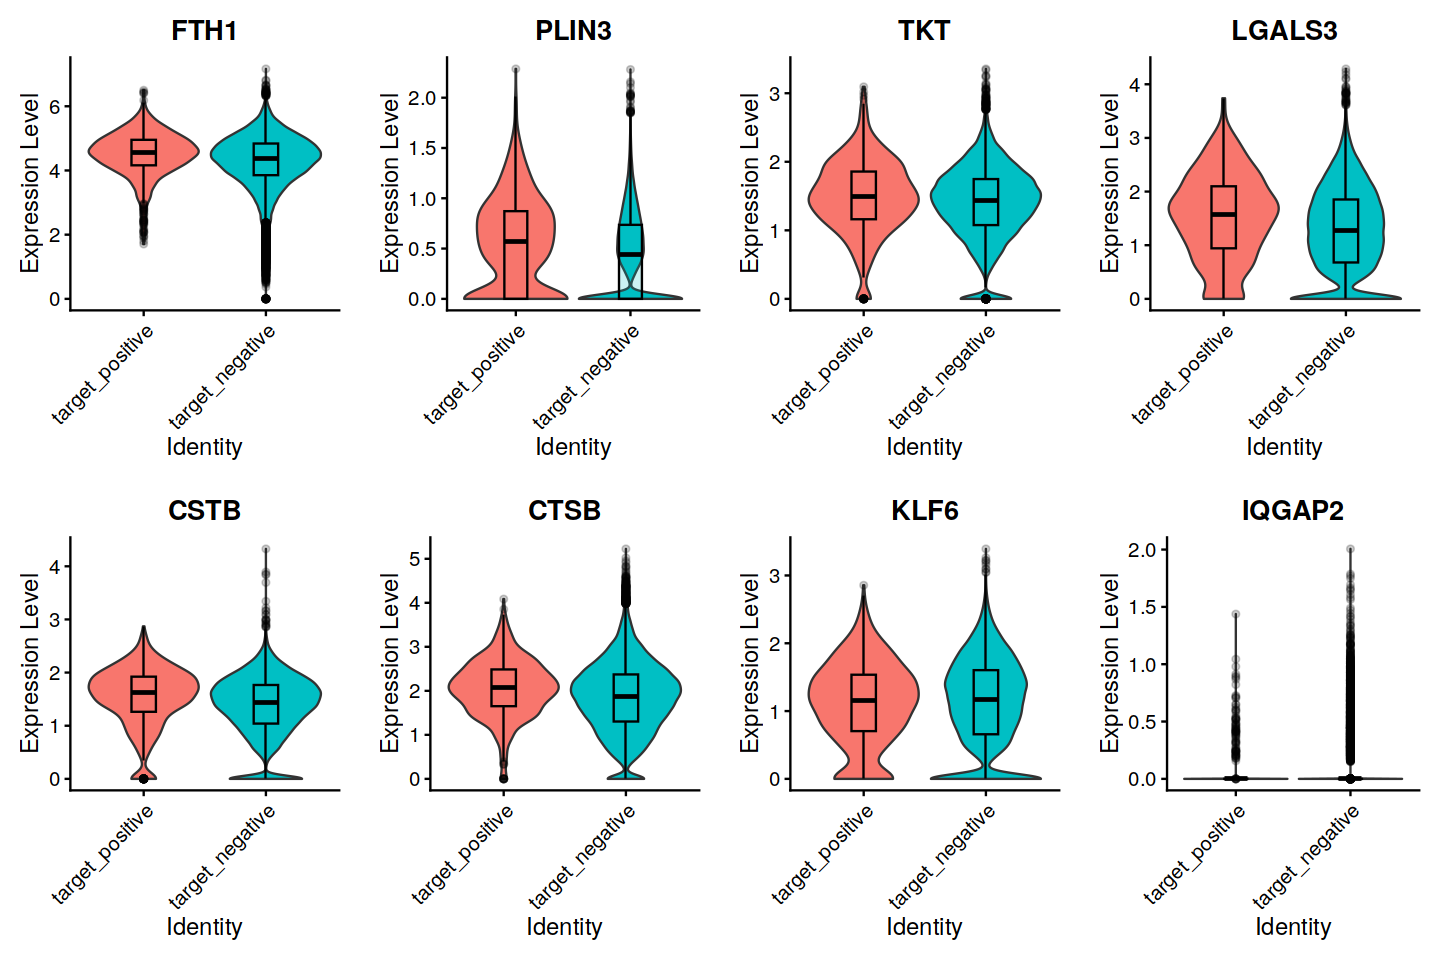

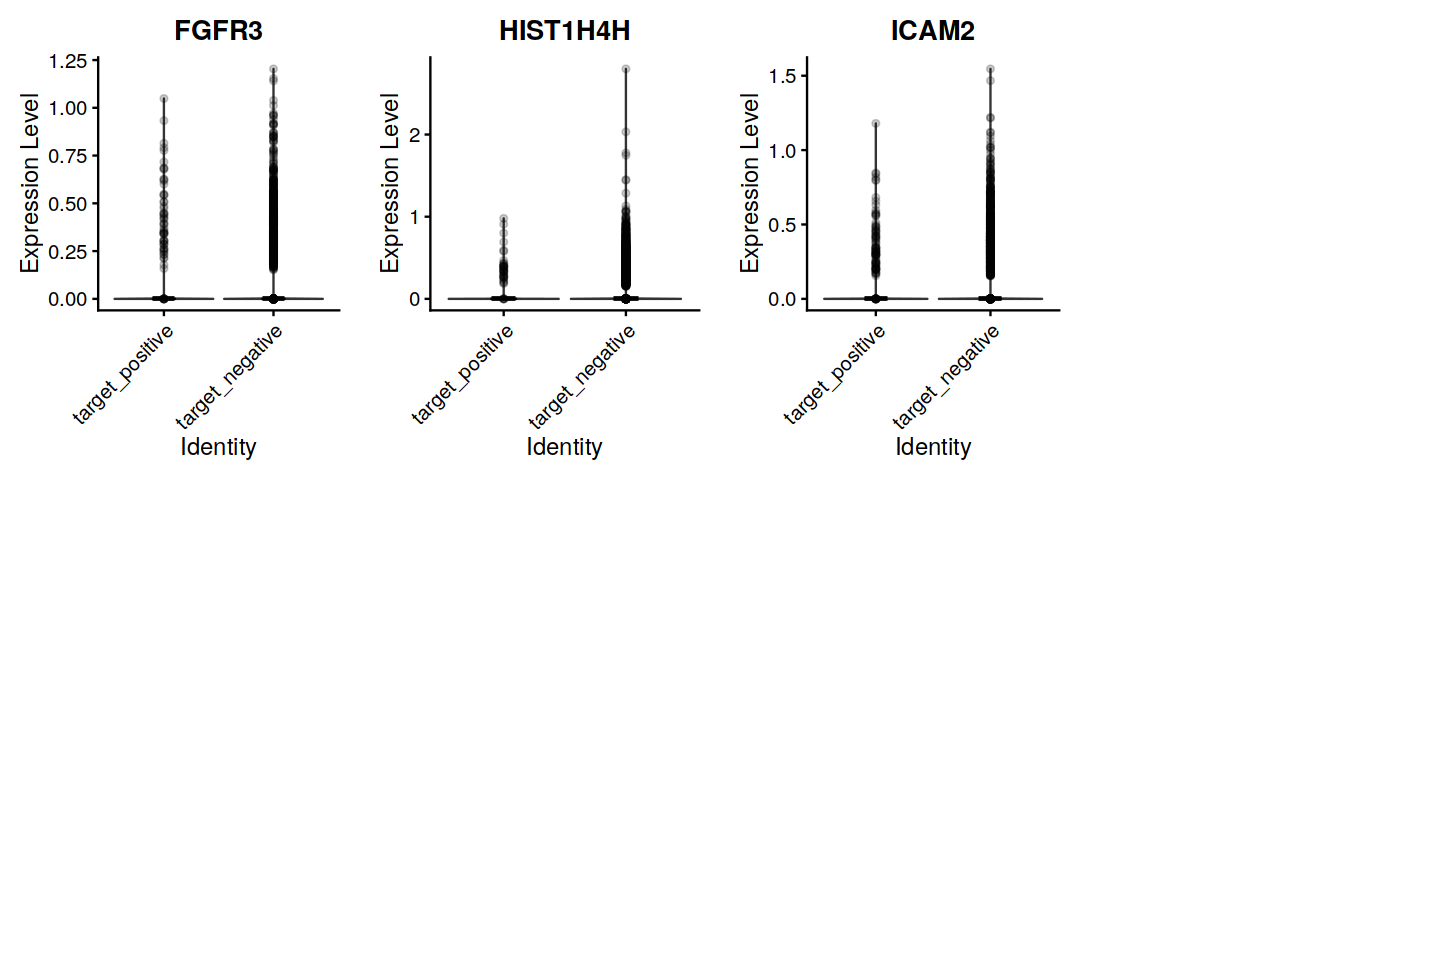

In [ ]:
targets = unique(filter(df_guide, subclass=='de_control')$alias)
plots = vlnplot_for_targets(seurat_rna, df_guide, perturbed_cells_by_guide, targets)
options(repr.plot.width=12, repr.plot.height=8)
ggarrange(plotlist=plots, ncol=4, nrow = 2)

## CKD DE 

[1] "DE22"
Guide+ = 1712 ; Guide- = 44339 
[1] "DE15"
Guide+ = 798 ; Guide- = 45253 


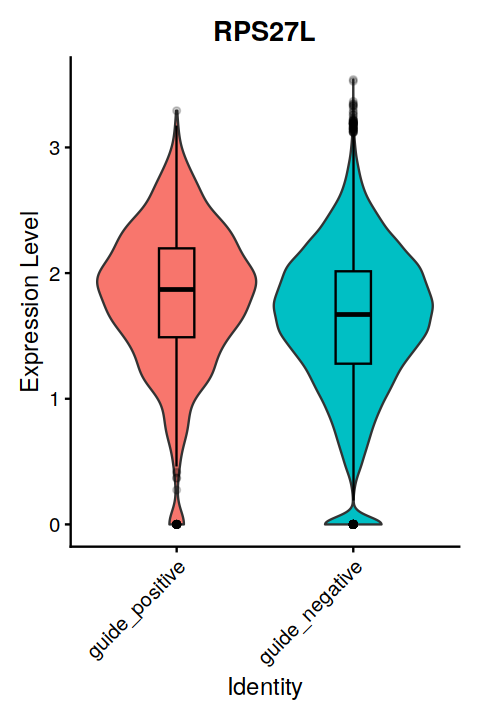

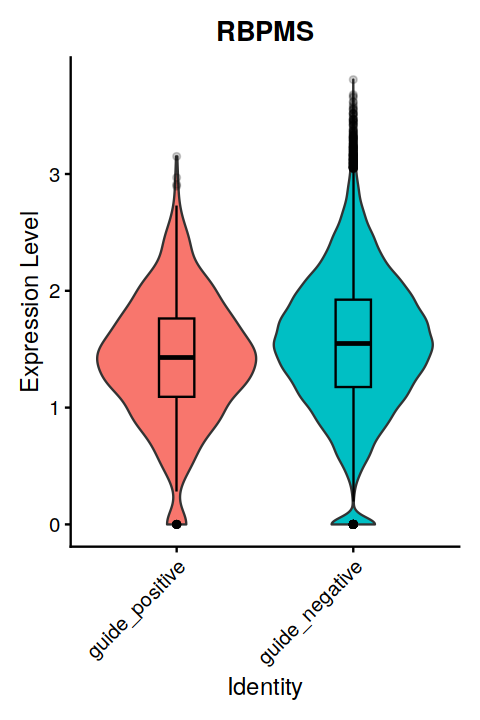

In [ ]:
target = "DE22"
regulated_gene = "RPS27L"
print(target)
guides = get_guides_by_subclass(df_guide, 'alias', target)
seurat_rna <- mark_guide_pos_neg(
    seurat_rna, 
    perturbed_cells_by_guide, 
    guides, 
    print_counts = T
)

plt1 <- VlnPlot(
    object = seurat_rna,
    features = regulated_gene, 
    idents = NULL, 
    pt.size = 0, 
    sort = F, 
    ncol = 1,    
) +
geom_boxplot(width=0.2, color="black", alpha=0.2) + 
theme(legend.position = 'none', plot.subtitle = element_text(hjust = 0.5))     



target = "DE15"
regulated_gene = "RBPMS"
print(target)
guides = get_guides_by_subclass(df_guide, 'alias', target)
seurat_rna <- mark_guide_pos_neg(
    seurat_rna, 
    perturbed_cells_by_guide, 
    guides, 
    print_counts = T
)

plt2 <- VlnPlot(
    object = seurat_rna,
    features = regulated_gene, 
    idents = NULL, 
    pt.size = 0, 
    sort = F, 
    ncol = 1,    
) +
geom_boxplot(width=0.2, color="black", alpha=0.2) + 
theme(legend.position = 'none', plot.subtitle = element_text(hjust = 0.5))     

options(repr.plot.width=4, repr.plot.height=6)
print(plt1) 
print(plt2)

### Violin plots for all DEs

In [ ]:
vlnplot_for_de_targets <- function(seurat_obj, df_guide, perturbed_cells_by_guide, df_target_vs_regulated) {
    plt_list = list()
    for(i in 1:nrow(df_target_vs_regulated)) {
        target = df_target_vs_regulated[i, 'target']
        regulated_gene = df_target_vs_regulated[i, 'de_gene']
        my_p_val = df_target_vs_regulated[i, 'p_val_adj_mine']
        my_p_val = formatC(my_p_val, format = "e", digits = 1)
        title = paste0(target, ": ", regulated_gene)
        subtitle = paste("Adjusted p =", my_p_val)
        
        guides = get_guides_by_subclass(df_guide, 'alias', target)
        seurat_dummy <- mark_target_pos_neg(
            seurat_rna,
            perturbed_cells_by_guide, 
            guides, 
            print_counts = F
        )

        options(repr.plot.width=5, repr.plot.height=4)
        plt <- VlnPlot(
            object = seurat_dummy,
            features =  regulated_gene, 
            idents = NULL, 
            pt.size = 0., 
            sort = F, 
            ncol = 1,    
        ) + 
            geom_boxplot(width=.2, color="black", alpha=0.2) + theme(legend.position = 'none') +
            labs(title = title, subtitle = subtitle)
        plt_list[[i]] = plt
    }
    plt_list
}


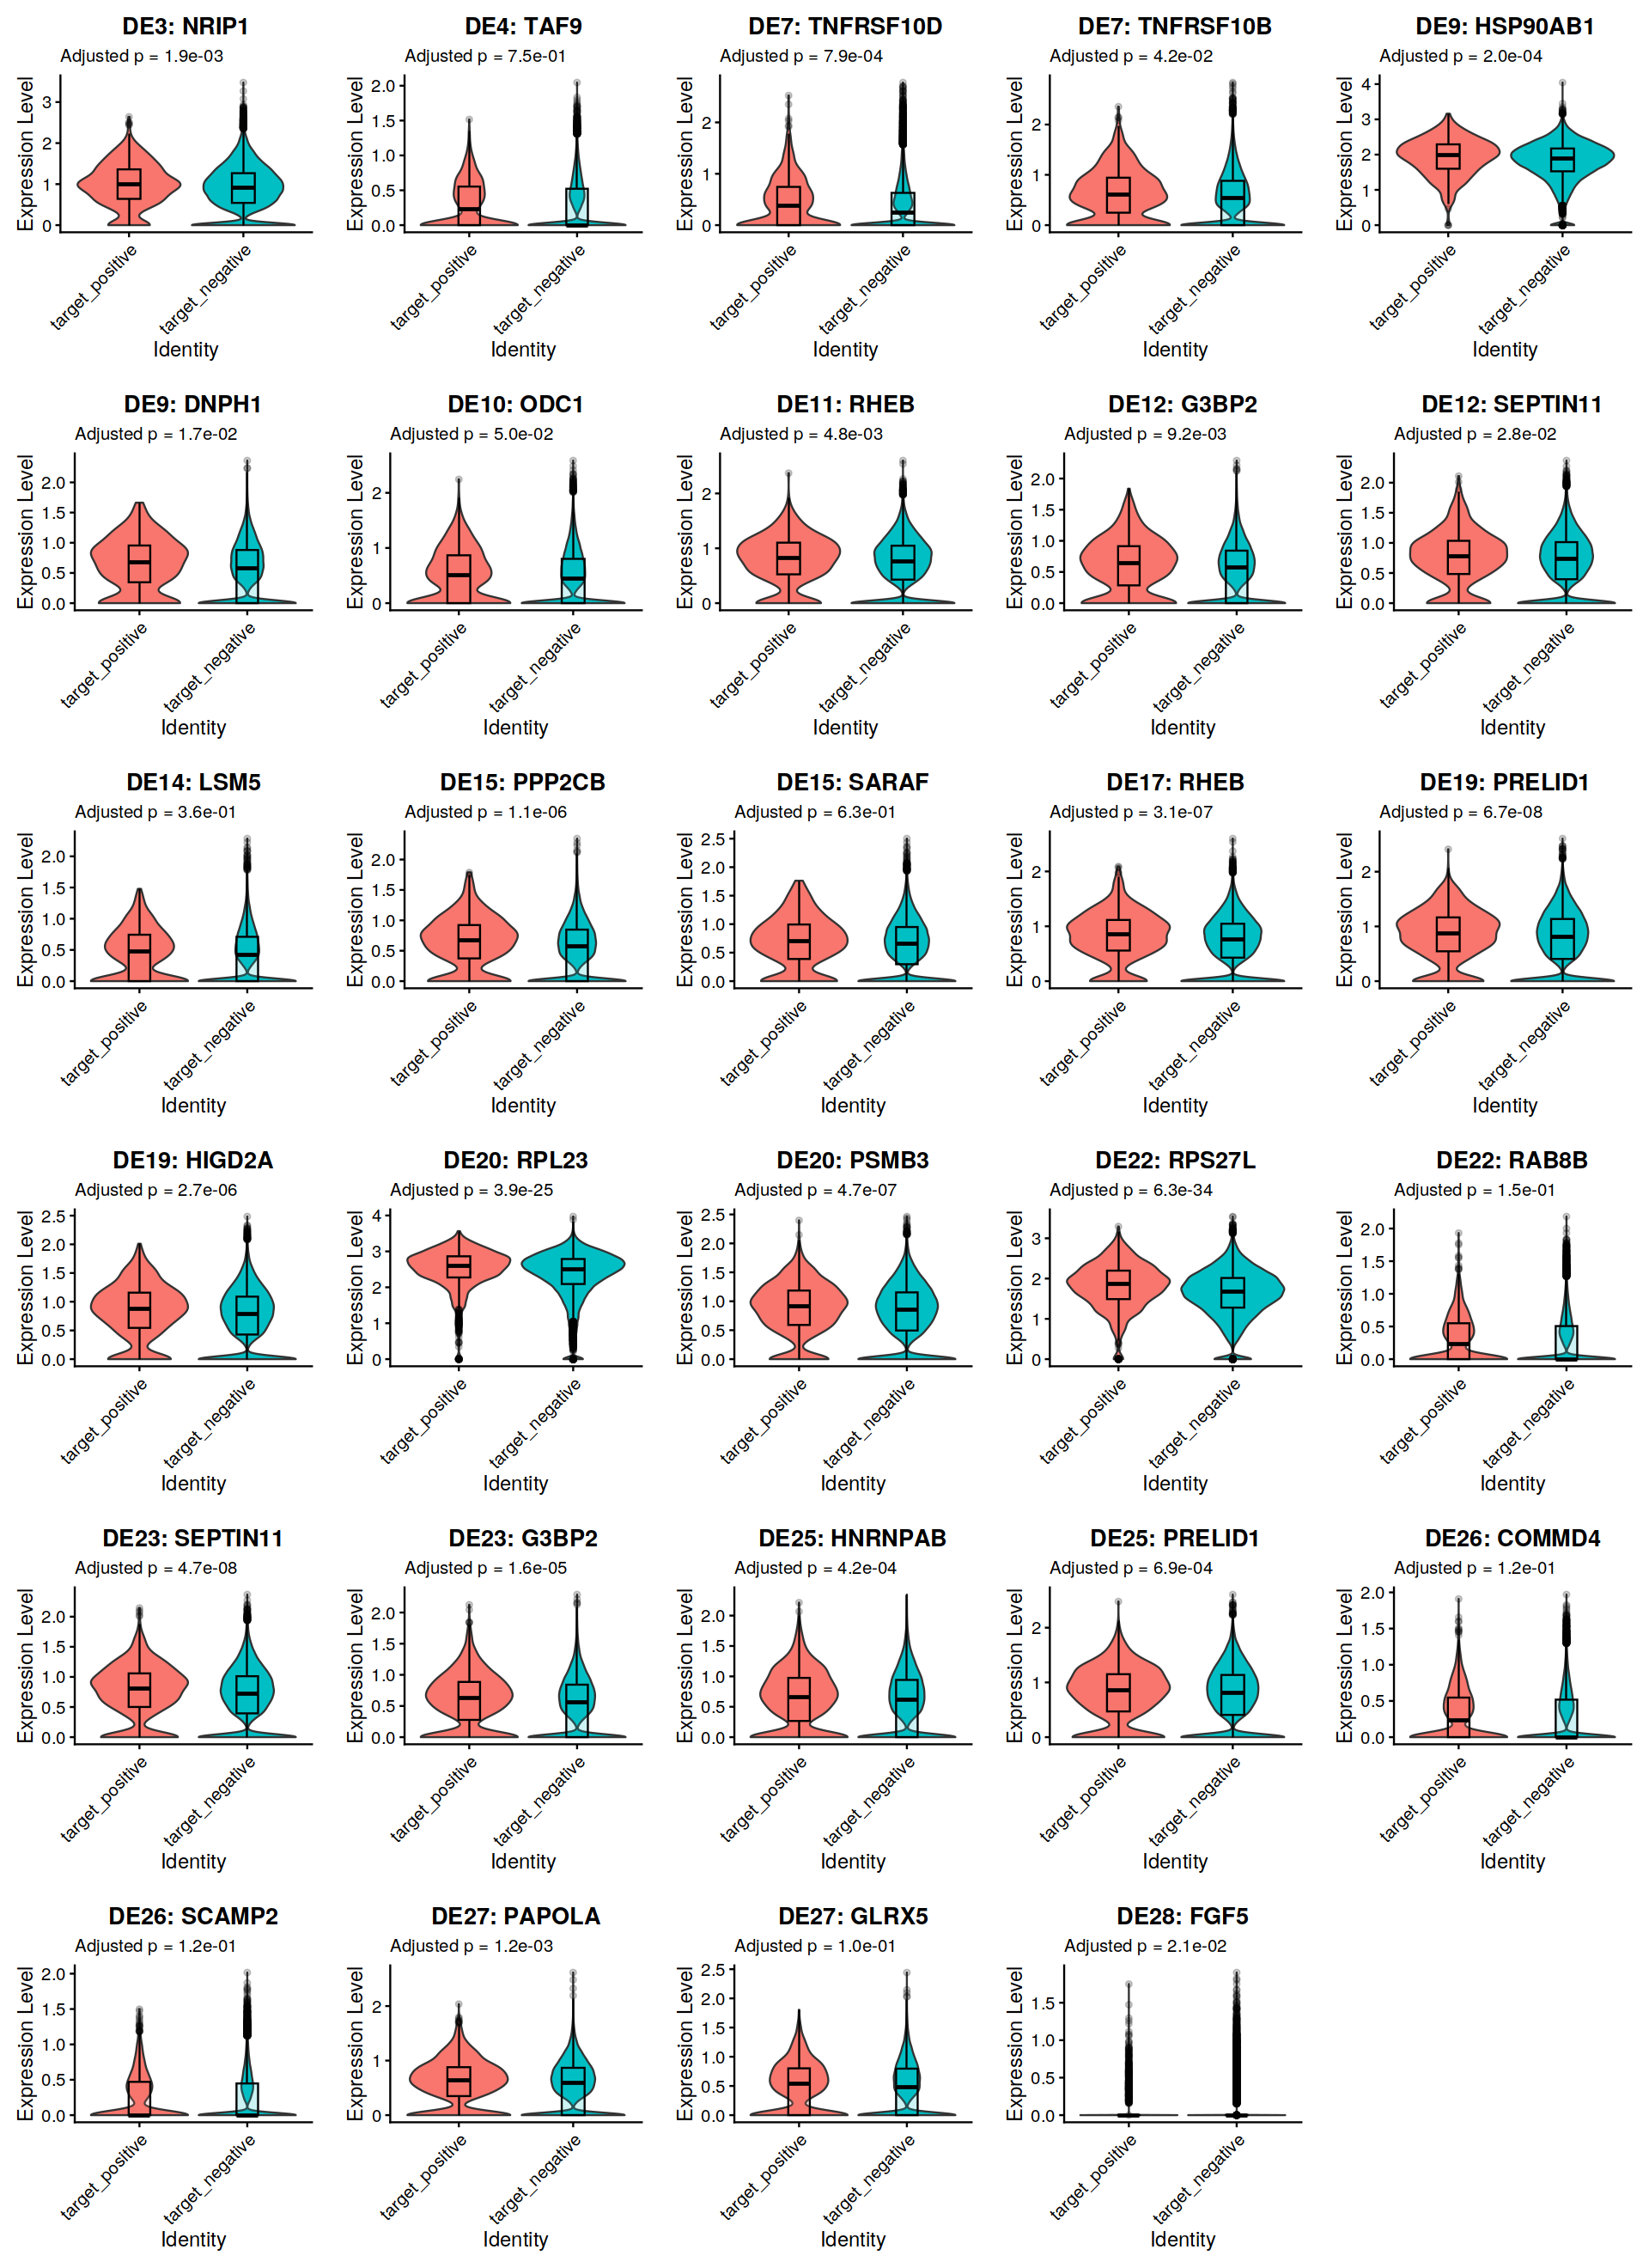

In [ ]:
df_top_distal_hits = df_top_hits %>% filter(label == "CKD DE")
df_target_vs_regulated = df_top_hits %>% filter(label == "CKD DE")
plots = vlnplot_for_de_targets(seurat_rna, df_guide, perturbed_cells_by_guide, df_top_distal_hits)

options(repr.plot.width=16, repr.plot.height=22)
ggarrange(plotlist=plots, ncol=5, nrow = 6)


# Debug